In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [2]:
root = os.path.dirname(os.getcwd())
data_dir = os.path.join(root, "data")
files = {
    "clinicalai": {
        "lymphoma": [file for file in os.listdir(data_dir) if ("lungc" in file or "lymph" in file) and "long_cleaned" not in file and "csv" in file],
        "oncology": [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" not in file and "cleaned_data_phase1" in file and "csv" in file]
    }
    }
files

{'clinicalai': {'lymphoma': ['cleaned_data_phase1_lymph_2bin_train.csv',
   'cleaned_data_phase1_lungc_2bin_test.csv'],
  'oncology': ['cleaned_data_phase1_2bin_test.csv',
   'cleaned_data_phase1_2bin_train.csv']}}

In [3]:
def train_and_retrain_model(model_type, data, train_data, drop_cols, root):
    file = [file for file in train_data[model_type][data] if "train" in file]
    df = pd.read_csv(os.path.join(root, "data", file[0]))

    y_cols = ["study_eq_labels"]

    X = df.drop(columns=y_cols+drop_cols)
    y = df[y_cols]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier()

    param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],        # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt']      # Number of features to consider at each split
    }

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    # Predict probabilities for each class
    y_pred_prob = best_model.predict_proba(X_test)

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_prob, axis=1) + 1

    # Evaluate the model
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average='weighted')
    mae = mean_absolute_error(y_test, y_pred)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

    # data
    data = {
        "data": file[0],
        "key": f"{model_type}_{data}",
        "accuracy": acc,
        "kfold mean accuracy": cv_results.mean(),
        "kfold stdev accuracy": cv_results.std(),
        "mae": mae,
        "precision": pre
    }

    data_df = pd.DataFrame([data])
    display(data_df)

    return best_model, data_df

def eval_model(model, model_type, data, train_data, drop_cols, root):
    file = [file for file in train_data[model_type][data] if "test" in file]
    df = pd.read_csv(os.path.join(root, "data", file[0]))

    y_cols = ["study_eq_labels"]

    X = df.drop(columns=y_cols+drop_cols)
    y = df[y_cols]
    
    y_pred = model.predict(X)

    acc = accuracy_score(y, y_pred)
    pre = precision_score(y, y_pred, average='weighted')
    mae = mean_absolute_error(y, y_pred)

    data = {
        "data": file[0],
        "model": f"{model_type} tuned",
        "key": f"{model_type}_{data}",
        "accuracy": acc,
        "mae": mae,
        "precision": pre
    }

    data_df = pd.DataFrame([data])
    display(data_df)

    return data_df

In [6]:
model_type = "clinicalai"
data = "oncology"
train_data = files

drop_cols = ['protocolSection_identificationModule_nctId',
                'primary_study_duration_days', 
                'study_duration_days',
                'primary_eq_bins',
                'study_eq_bins',
                'primary_eq_labels',
]

file = [file for file in train_data[model_type][data] if "train" in file]
df = pd.read_csv(os.path.join(root, "data", file[0]))

y_cols = ["study_eq_labels"]

X = df.drop(columns=y_cols+drop_cols)
y = df[y_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()

# param_grid = {
# 'n_estimators': [100, 200, 300],      # Number of trees in the forest
# 'max_depth': [None, 10, 20, 30],      # Maximum depth of the tree
# 'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split an internal node
# 'min_samples_leaf': [1, 2, 4],        # Minimum number of samples required to be at a leaf node
# 'max_features': ['auto', 'sqrt']      # Number of features to consider at each split
# }

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

# best_model = grid_search.best_estimator_
# Predict probabilities for each class
y_pred_prob = model.predict_proba(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1) + 1

# Evaluate the model
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average='weighted')
mae = mean_absolute_error(y_test, y_pred)
cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

# data
data = {
    "data": file[0],
    "key": f"{model_type}_{data}",
    "accuracy": acc,
    "kfold mean accuracy": cv_results.mean(),
    "kfold stdev accuracy": cv_results.std(),
    "mae": mae,
    "precision": pre
}

data_df = pd.DataFrame([data])

data_df

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/sit

,data,key,accuracy,kfold mean accuracy,kfold stdev accuracy,mae,precision
0,cleaned_data_phase1_2bin_train.csv,clinicalai_oncology,0.153605,0.728894,0.009242,0.979624,0.150337


In [8]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importance ranking
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance (descending)
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

,Feature,Importance
14,enroll_count,0.155461
30,secondary_max_days,0.108673
29,primary_max_days,0.100002
5,num_inclusion,0.090108
6,num_exclusion,0.079688
3,num_locations,0.065710
31,survival_5yr_relative,0.043985
8,sponsor_type,0.043308
7,number_of_intervention_types,0.043279
4,location,0.034556


In [44]:
importance_df.tail(10)['Feature'].to_list()

['ae_outcome_measure',
 'phase_PHASE1',
 'resp_party',
 'os_outcome_measure',
 'allocation',
 'phase_PHASE1_PHASE2',
 'dor_outcome_measure',
 'age_group',
 'treatment_purpose',
 'masking']

# Correlation Matrix

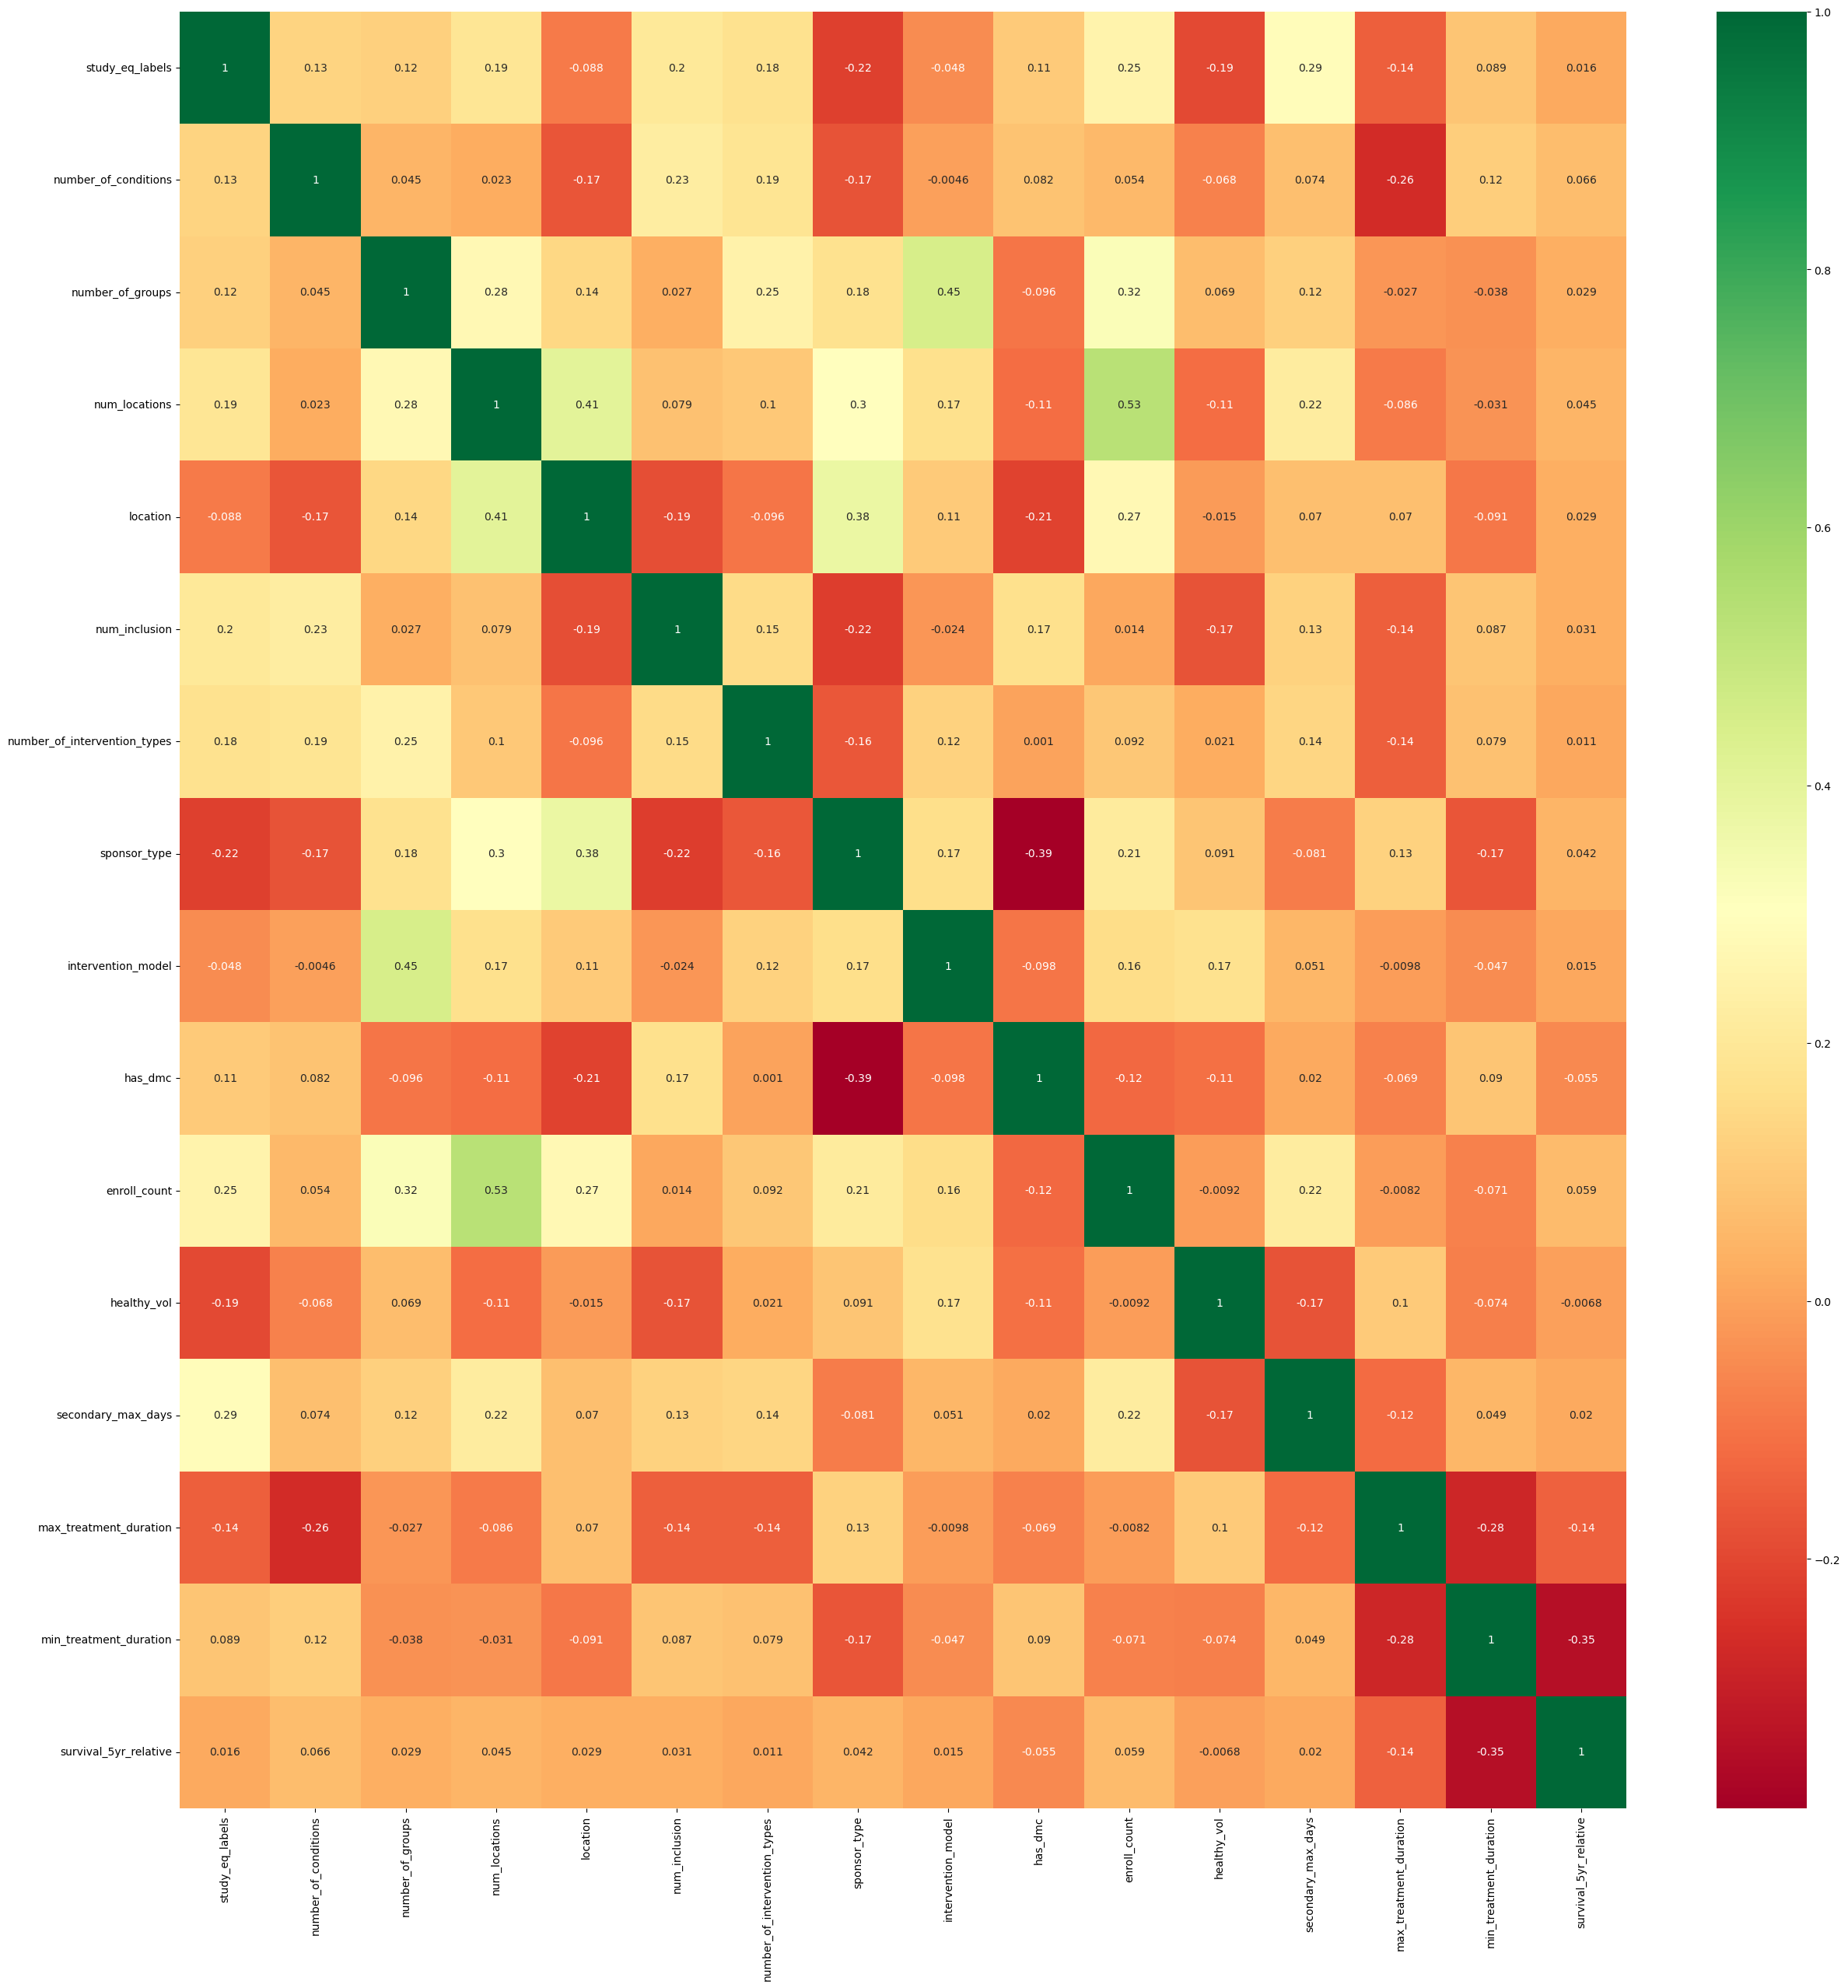

In [49]:
# train_data = files
# model_type = model
# file = [file for file in train_data[model_type][data] if "train" in file]
# df = pd.read_csv(os.path.join(root, "data", file[0]))

# y_cols = ["study_eq_labels"]

# X = df.drop(columns=y_cols+drop_cols)
# y = df[y_cols]
X = df.drop(columns=drop_cols)

temp_df = X.loc[:, (X != X.iloc[0]).any()]  # Keep columns with more than one unique value
corrmat = temp_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## dropped the columns that only had one unique value

In [23]:
len(X.columns)

36

In [24]:
len(temp_df.columns)

27

In [25]:
overlap = [x for x in X.columns if x not in temp_df.columns]
len(overlap)

9

In [26]:
overlap

['diagnostic_purpose',
 'prevention_purpose',
 'supportive_purpose',
 'procedure_intervention',
 'device_intervention',
 'behavioral_intervention',
 'drug_intervention',
 'radiation_intervention',
 'biological_intervention']

# Drop some low correlation features to see if it improves model performance

In [15]:
corr_with_y = temp_df.corrwith(y).abs()

to_drop = set()
threshold = 0.1

# remove features that are more correlated with one another than they are with the y variable
# also remove features that are correlated below the set threshold with the y variable

# Step 1: Identify and drop features that are more correlated with each other than with y
for i in range(len(corrmat.columns)):
    for j in range(i):
        # Check if correlation between features i and j is higher than correlation with y
        if abs(corrmat.iloc[i, j]) > corr_with_y.iloc[i] and abs(corrmat.iloc[i, j]) > corr_with_y.iloc[j]:
            # Drop the feature with the lower correlation with y
            if corr_with_y.iloc[i] < corr_with_y.iloc[j]:
                to_drop.add(corrmat.columns[i])
                # print(f"Dropping feature due to high pairwise correlation: {corrmat.columns[i]}")

            else:
                to_drop.add(corrmat.columns[j])
                # print(f"Dropping feature due to high pairwise correlation: {corrmat.columns[i]}")


# Step 2: Drop features that are not part of a highly correlated pair and have correlation with y less than the threshold
for column in corrmat.columns:
    if column not in to_drop and corr_with_y[column] < threshold:
        to_drop.add(column)  # Drop any feature with correlation to y below 0.2
        # print(f"Dropping feature due to low correlation with y: {column}")


to_drop

set()

In [16]:
corr_with_y

ae_outcome_measure             NaN
age_group                      NaN
allocation                     NaN
dor_outcome_measure            NaN
enroll_count                   NaN
has_dmc                        NaN
healthy_vol                    NaN
intervention_model             NaN
location                       NaN
masking                        NaN
max_treatment_duration         NaN
min_treatment_duration         NaN
num_exclusion                  NaN
num_inclusion                  NaN
num_locations                  NaN
number_of_conditions           NaN
number_of_groups               NaN
number_of_intervention_types   NaN
os_outcome_measure             NaN
phase_PHASE1                   NaN
phase_PHASE1_PHASE2            NaN
primary_max_days               NaN
resp_party                     NaN
secondary_max_days             NaN
sponsor_type                   NaN
study_eq_labels                NaN
survival_5yr_relative          NaN
treatment_purpose              NaN
dtype: float64

In [4]:
num_bins = len(data["study_eq_bins"].unique())
num_bins

3

In [5]:
exclude_cols = [
    'protocolSection_identificationModule_nctId', 'primary_eq_bins',
    'study_eq_bins', "primary_study_duration_days", "study_duration_days", "primary_eq_labels", "study_eq_labels"]

X = data.drop(columns=exclude_cols)
y = data['study_eq_labels']

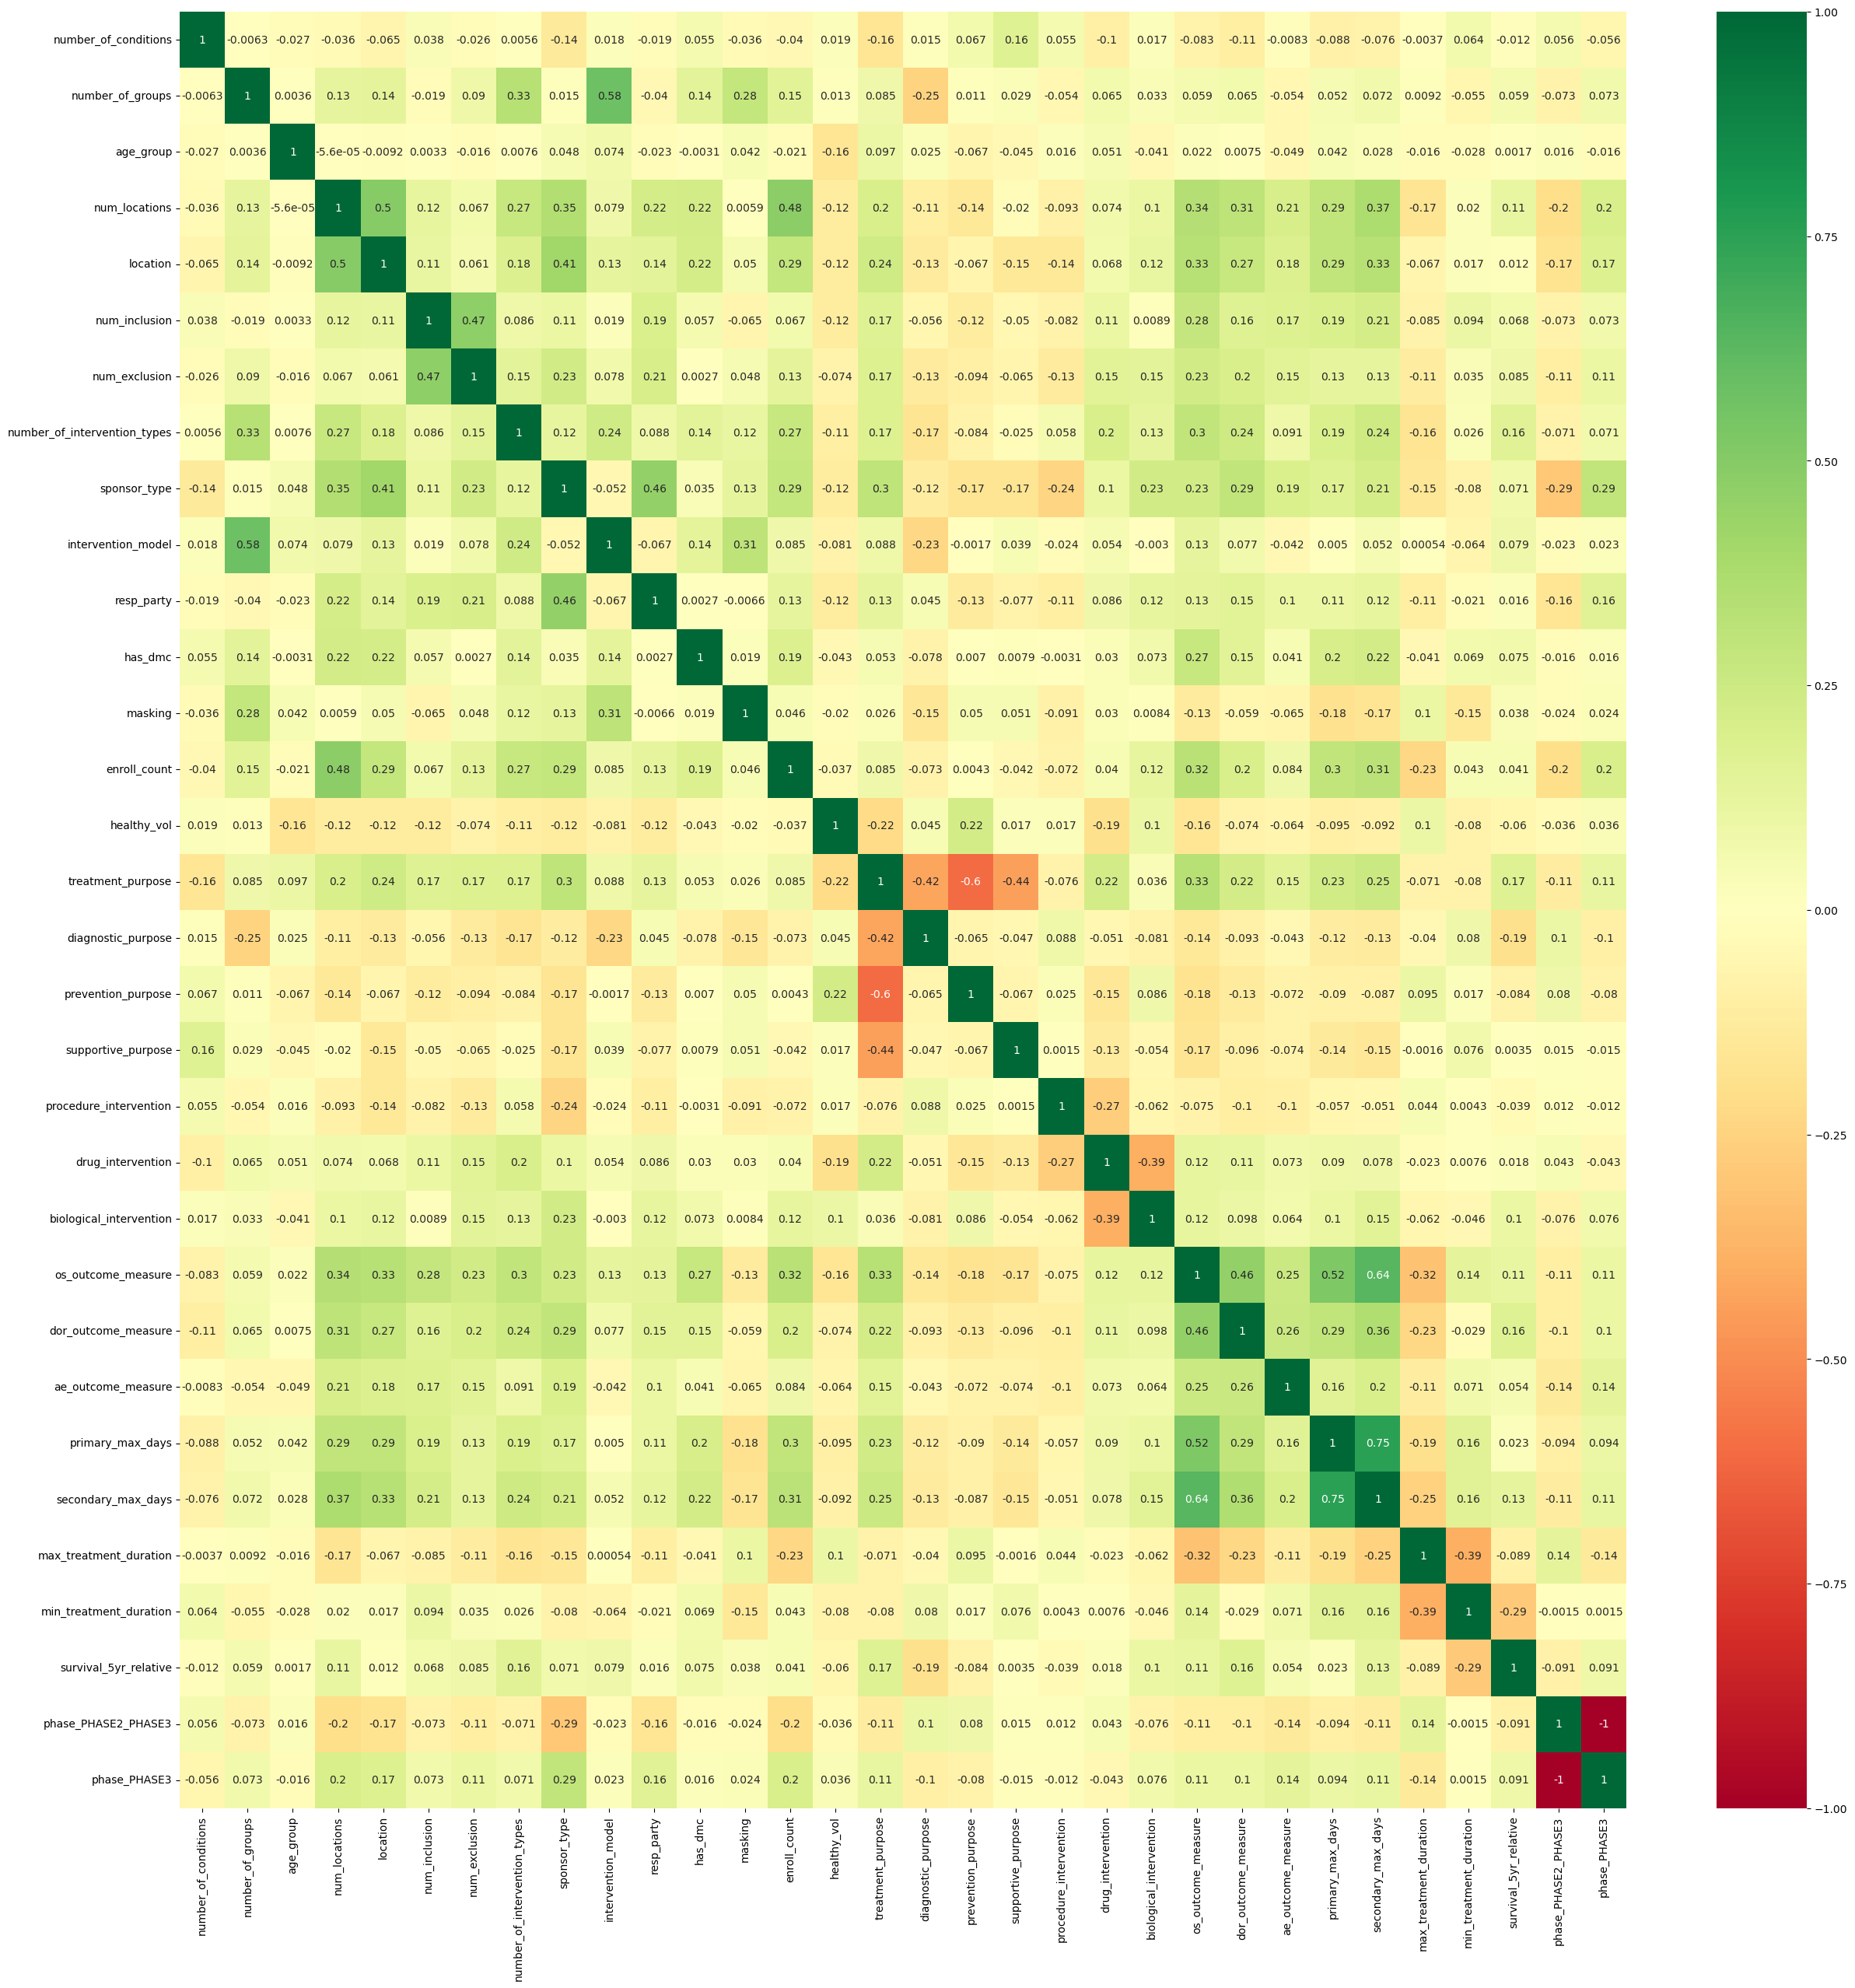

In [6]:
temp_df = X.loc[:, (X != X.iloc[0]).any()]  # Keep columns with more than one unique value
corrmat = temp_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [7]:
corr_with_y = X.corrwith(y).abs()

to_drop = set()
threshold = 0.1

# remove features that are more correlated with one another than they are with the y variable
# also remove features that are correlated below the set threshold with the y variable

# Step 1: Identify and drop features that are more correlated with each other than with y
for i in range(len(corrmat.columns)):
    for j in range(i):
        # Check if correlation between features i and j is higher than correlation with y
        if abs(corrmat.iloc[i, j]) > corr_with_y.iloc[i] and abs(corrmat.iloc[i, j]) > corr_with_y.iloc[j]:
            # Drop the feature with the lower correlation with y
            if corr_with_y.iloc[i] < corr_with_y.iloc[j]:
                to_drop.add(corrmat.columns[i])
                # print(f"Dropping feature due to high pairwise correlation: {corrmat.columns[i]}")

            else:
                to_drop.add(corrmat.columns[j])
                # print(f"Dropping feature due to high pairwise correlation: {corrmat.columns[i]}")


# Step 2: Drop features that are not part of a highly correlated pair and have correlation with y less than the threshold
for column in corrmat.columns:
    if column not in to_drop and corr_with_y[column] < threshold:
        to_drop.add(column)  # Drop any feature with correlation to y below 0.2
        # print(f"Dropping feature due to low correlation with y: {column}")


to_drop

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


{'age_group',
 'biological_intervention',
 'dor_outcome_measure',
 'drug_intervention',
 'enroll_count',
 'intervention_model',
 'location',
 'min_treatment_duration',
 'num_exclusion',
 'number_of_conditions',
 'number_of_groups',
 'phase_PHASE3',
 'prevention_purpose',
 'primary_max_days',
 'procedure_intervention',
 'resp_party',
 'sponsor_type',
 'supportive_purpose',
 'survival_5yr_relative',
 'treatment_purpose'}

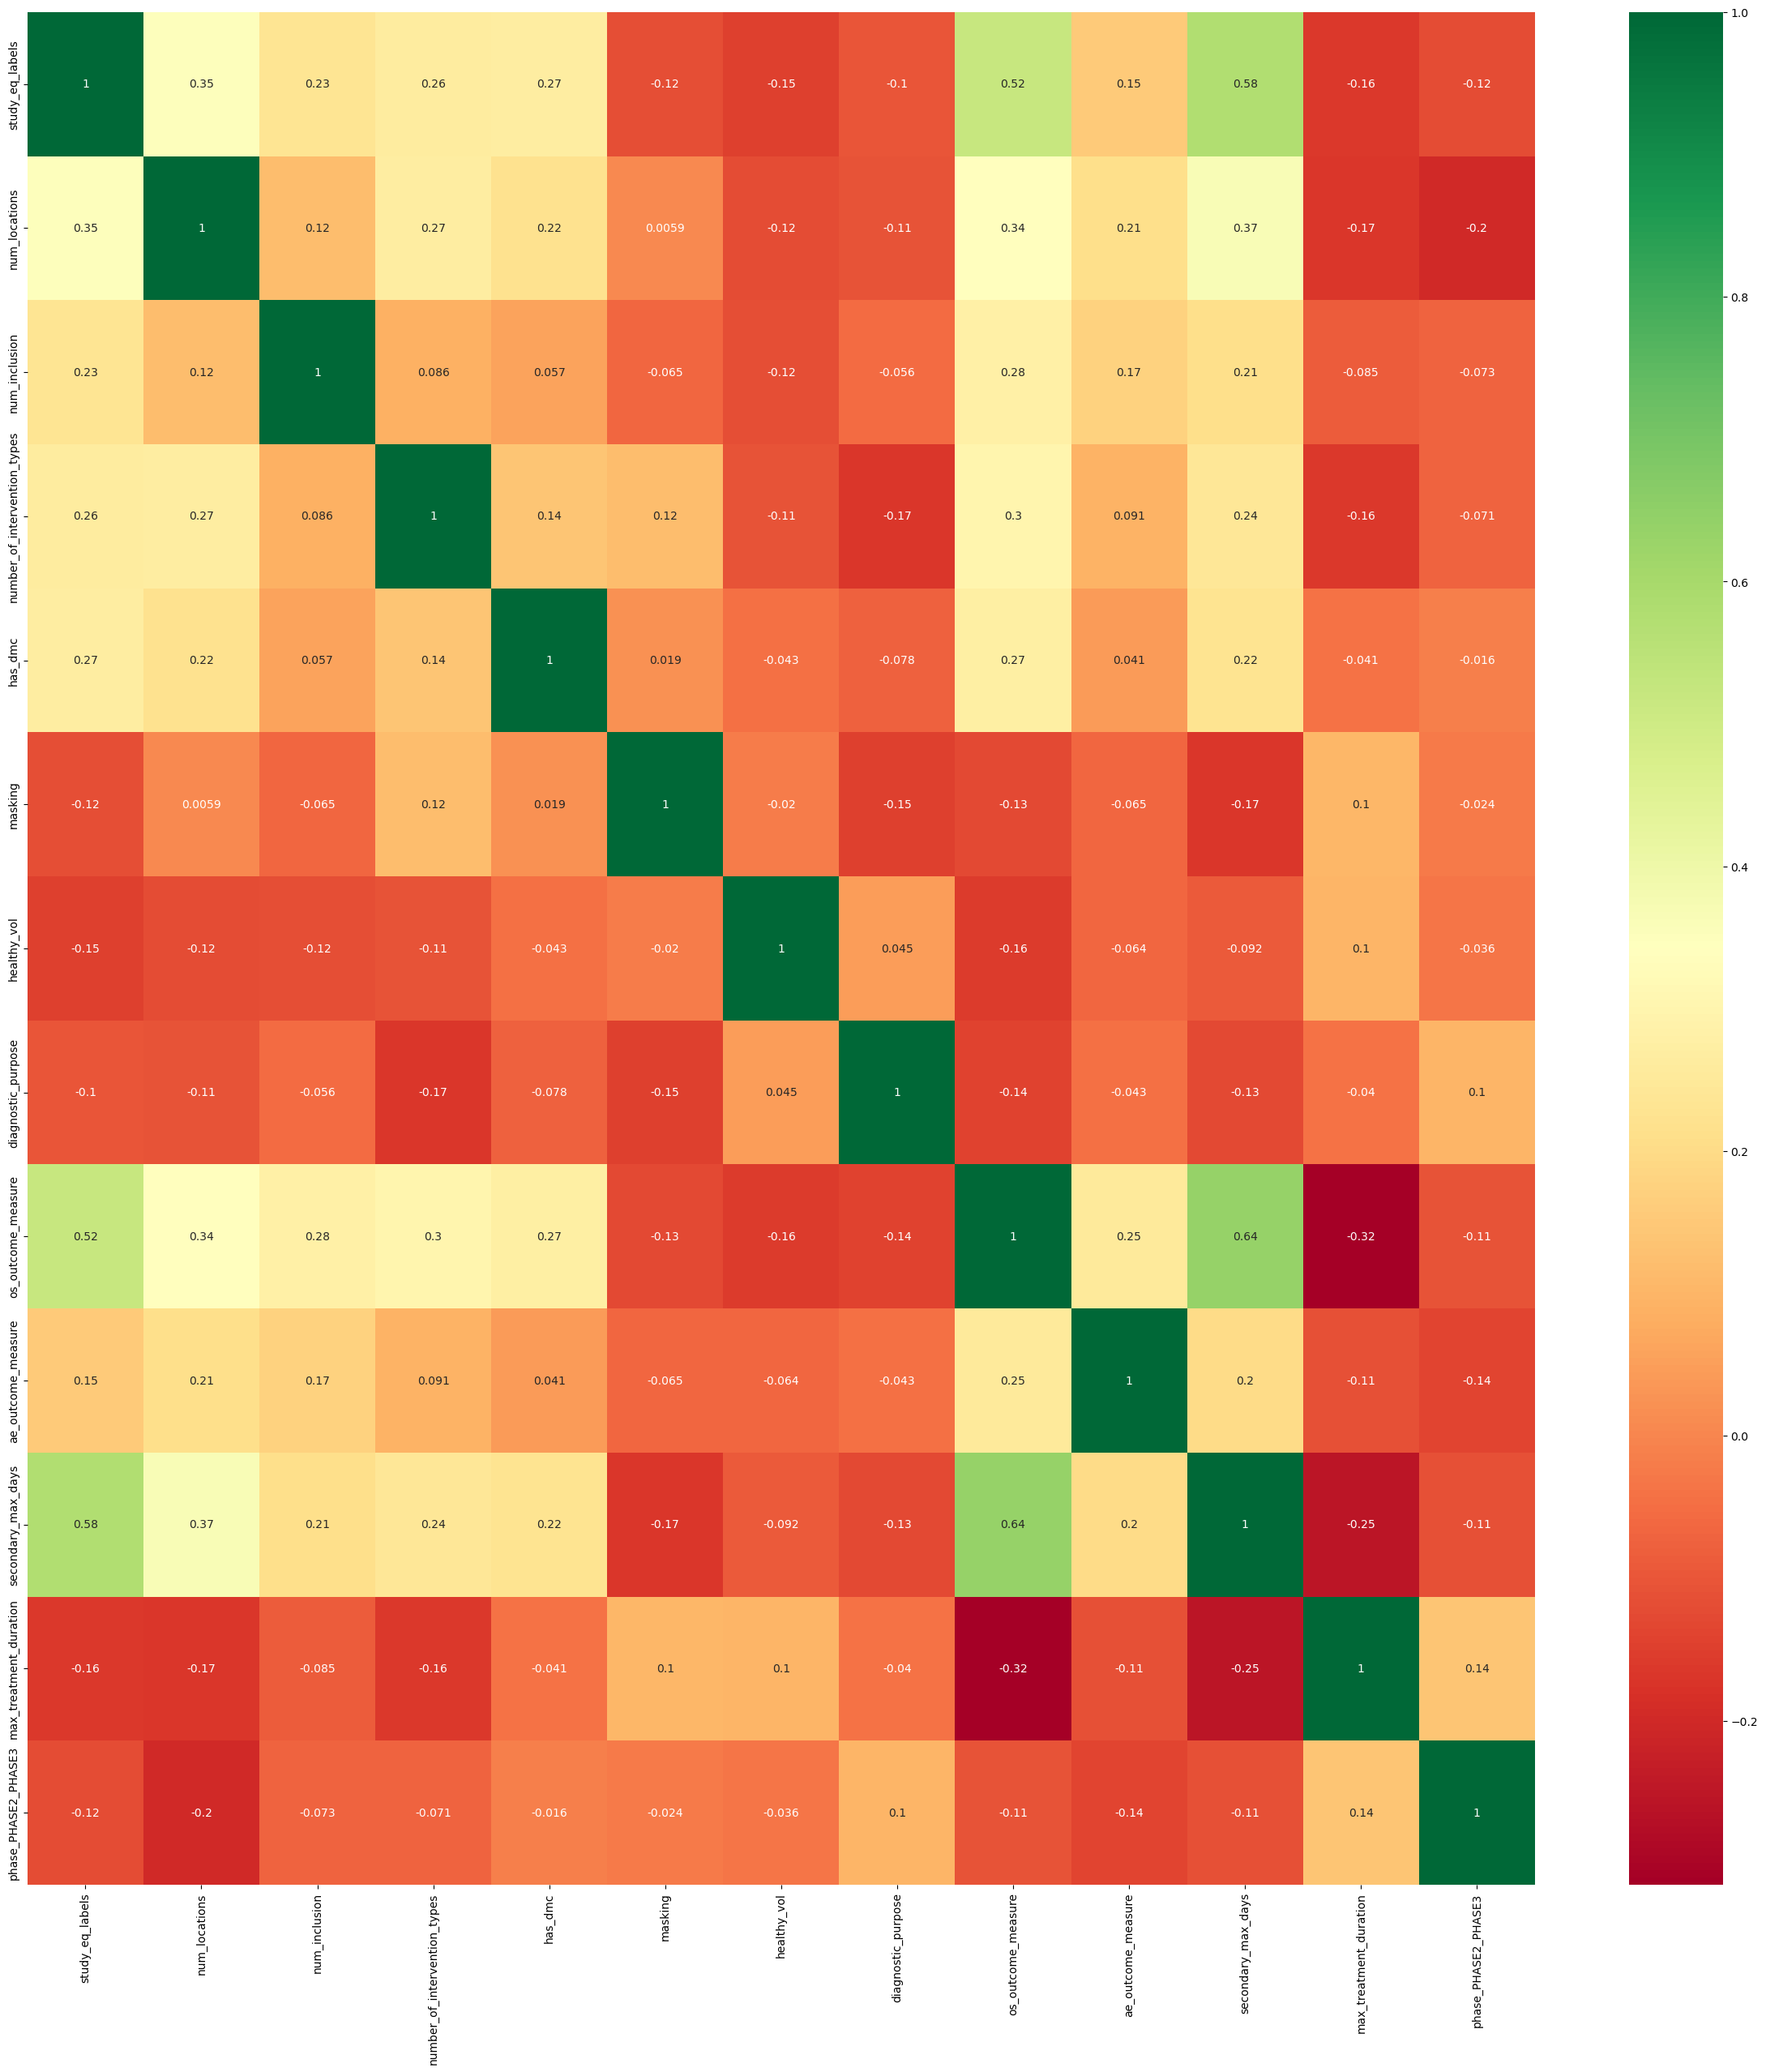

In [8]:
all_cols_drop = list(to_drop) + [i for i in exclude_cols if 'study_eq_labels' not in i]
data_reduced = data.drop(columns=all_cols_drop)
reduced_df = data_reduced.loc[:, (data_reduced != data_reduced.iloc[0]).any()]  # Keep columns with more than one unique value
corrmat2 = reduced_df.corr()
top_corr_features2 = corrmat2.index
plt.figure(figsize=(30,30))
#plot heat map
g=sns.heatmap(data_reduced[top_corr_features2].corr(),annot=True,cmap="RdYlGn")

In [9]:
corrmat2['study_eq_labels'].sort_values(ascending=False)

study_eq_labels                 1.000000
secondary_max_days              0.576378
os_outcome_measure              0.520689
num_locations                   0.348568
has_dmc                         0.266242
number_of_intervention_types    0.261403
num_inclusion                   0.233794
ae_outcome_measure              0.152508
diagnostic_purpose             -0.104391
masking                        -0.115056
phase_PHASE2_PHASE3            -0.122676
healthy_vol                    -0.149831
max_treatment_duration         -0.162352
Name: study_eq_labels, dtype: float64

In [10]:
filtered_columns = corrmat2['study_eq_labels'][(corrmat2['study_eq_labels'] > 0.1) & (corrmat2['study_eq_labels'] < 1)].index.to_list()
filtered_columns

['num_locations',
 'num_inclusion',
 'number_of_intervention_types',
 'has_dmc',
 'os_outcome_measure',
 'ae_outcome_measure',
 'secondary_max_days']

In [11]:
data_reduced.columns

Index(['study_eq_labels', 'num_locations', 'num_inclusion',
       'number_of_intervention_types', 'has_dmc', 'allocation', 'masking',
       'healthy_vol', 'diagnostic_purpose', 'device_intervention',
       'behavioral_intervention', 'radiation_intervention',
       'os_outcome_measure', 'ae_outcome_measure', 'secondary_max_days',
       'max_treatment_duration', 'phase_PHASE2_PHASE3'],
      dtype='object')

In [12]:
cols = 'study_eq_labels'
reduced_y = data_reduced['study_eq_labels']
reduced_X = data_reduced.drop(columns=cols)

X_train, X_test, y_train, y_test = train_test_split(reduced_X, reduced_y, test_size=0.2, random_state=42)

In [13]:
model =  RandomForestClassifier(max_depth=None,
                                min_samples_leaf=1,
                                min_samples_split=2,
                                n_estimators=100)

In [14]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform k-fold cross-validation
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')

model.fit(X_train, y_train)

# Predict probabilities for each class
y_pred_prob = model.predict_proba(X_test)
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1) + 1

mse = mean_squared_error(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average='weighted')
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

row = {
    # 'model': type,
    'accuracy': acc,
    'mean_accuracy_kfold': cv_results.mean(),
    'precision': pre,
    'r_squared': r2,
    'mean_squared_error': mse,
    'mean_absolute_error': mae,
}
print(row)

{'accuracy': 0.14432989690721648, 'mean_accuracy_kfold': 0.5915301902398676, 'precision': 0.1421197168619849, 'r_squared': -0.9093891579440714, 'mean_squared_error': 1.2989690721649485, 'mean_absolute_error': 1.0}


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
# Load the trained Random Forest model
model_path = 'model_rf.pkl'
rf_model = joblib.load(model_path)

# Assuming the target column is 'target'
exclude_columns = [
    'protocolSection_identificationModule_nctId',
    'study_eq_labels', 
    'study_duration_days', 
    'primary_eq_labels', 
    'primary_study_duration_days',
    'primary_eq_bins',
    'study_eq_bins']
target = 'study_eq_labels'
X = data_reduced.drop(columns=exclude_columns)
y = data_reduced[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
# Initialize a DataFrame to store the results
results = pd.DataFrame(columns=['feature_dropped', 'accuracy', 'precision', 'mean_squared_error', 'mean_absolute_error'])

# Get the list of features
features = X.columns.tolist()

for feature in features:
    # Drop the feature
    X_train_dropped = X_train.drop(columns=[feature])
    X_test_dropped = X_test.drop(columns=[feature])

    # Retrain the model
    rf_model.fit(X_train_dropped, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test_dropped)
    # y_pred_proba = rf_model.predict_proba(X_test_dropped)[:, 1]

    # Calculate performance metrics
    # accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average='weighted')
    mae = mean_absolute_error(y_test, y_pred)
    # roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    row = {
        'feature_dropped': feature,
        'accuracy': acc,
        'precision': pre,
        'mean_squared_error': mse,
        'mean_absolute_error': mae
    }
    # df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    # Store the results
    results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)

# results


/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_3008/1313447027.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)


In [12]:
results = results.sort_values(by='mean_absolute_error', ascending=False)
styled_df = results.style.background_gradient(cmap='Greens') \
                 .set_caption('Feature Importance')
styled_df


,feature_dropped,accuracy,precision,mean_squared_error,mean_absolute_error
17,os_outcome_measure,0.520619,0.502845,0.819588,0.592784
3,num_locations,0.572165,0.568577,0.690722,0.515464
5,number_of_intervention_types,0.556701,0.538776,0.644330,0.510309
6,has_dmc,0.592784,0.592537,0.701031,0.505155
7,allocation,0.572165,0.556636,0.644330,0.500000
9,healthy_vol,0.582474,0.564085,0.634021,0.489691
8,masking,0.597938,0.585085,0.649485,0.484536
22,phase_PHASE2_PHASE3,0.577320,0.554878,0.592784,0.479381
14,drug_intervention,0.587629,0.565175,0.597938,0.474227
16,biological_intervention,0.592784,0.574352,0.608247,0.474227


In [13]:
iter = len(results)//3
iter

7

In [14]:
df = results.copy()

results2 = pd.DataFrame(columns=['feature_dropped', 'accuracy', 'precision', 'mean_squared_error', 'mean_absolute_error'])


for i in range(iter):
    df = df.sort_values(by='mean_absolute_error')
    # Get the top 3 features with the lowest MAE
    features_to_drop = df.head(3)['feature_dropped'].tolist()
    # Update the df
    df = df[~df['feature_dropped'].isin(features_to_drop)]

    # print(features_to_drop)

    # display(df)
    
    # Append the dropped features to the list
    # Drop the feature
    X_train_dropped = X_train.drop(columns=features_to_drop)
    X_test_dropped = X_test.drop(columns=features_to_drop)

    # Retrain the model
    rf_model.fit(X_train_dropped, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test_dropped)
    # y_pred_proba = rf_model.predict_proba(X_test_dropped)[:, 1]

    # Calculate performance metrics
    # accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average='weighted')
    mae = mean_absolute_error(y_test, y_pred)
    # roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    row = {
        'feature_dropped': [features_to_drop],
        'accuracy': acc,
        'precision': pre,
        'mean_squared_error': mse,
        'mean_absolute_error': mae
    }
    # df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    # Store the results
    results2 = pd.concat([results2, pd.DataFrame([row])], ignore_index=True)
# results2

/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_3008/4204564789.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results2 = pd.concat([results2, pd.DataFrame([row])], ignore_index=True)


In [15]:
results2 = results2.sort_values(by='mean_absolute_error', ascending=False)
styled_df = results2.style.background_gradient(cmap='Greens') \
                 .set_caption('Feature Importance')
styled_df

,feature_dropped,accuracy,precision,mean_squared_error,mean_absolute_error
2,"[['treatment_purpose', 'device_intervention', 'survival_5yr_relative']]",0.561856,0.545783,0.685567,0.520619
5,"[['phase_PHASE2_PHASE3', 'masking', 'healthy_vol']]",0.561856,0.544934,0.670103,0.515464
6,"[['allocation', 'has_dmc', 'number_of_intervention_types']]",0.577320,0.558290,0.639175,0.494845
0,"[['max_treatment_duration', 'behavioral_intervention', 'age_group']]",0.597938,0.572902,0.556701,0.453608
4,"[['biological_intervention', 'drug_intervention', 'radiation_intervention']]",0.613402,0.597121,0.572165,0.448454
1,"[['number_of_conditions', 'min_treatment_duration', 'ae_outcome_measure']]",0.603093,0.587022,0.536082,0.443299
3,"[['num_inclusion', 'number_of_groups', 'procedure_intervention']]",0.613402,0.596785,0.556701,0.443299


In [9]:
df = results.copy()

results3 = pd.DataFrame(columns=['feature_dropped', 'accuracy', 'precision', 'mean_squared_error', 'mean_absolute_error'])

features_dropped = []

for i in range(len(df)-1):
    df = df.sort_values(by='mean_absolute_error')
    # Get the next feature to drop
    next_feature_to_drop = df.iloc[0]['feature_dropped']
    # print(next_feature_to_drop)
    # Add the new feature to the list of features to drop
    features_dropped.append(next_feature_to_drop)
    # Update the df
    df = df[~df['feature_dropped'].isin(features_dropped)]

    # print(features_dropped)

    # Drop the feature
    X_train_dropped = X_train.drop(columns=features_dropped)
    X_test_dropped = X_test.drop(columns=features_dropped)

    # Retrain the model
    rf_model.fit(X_train_dropped, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test_dropped)
    # y_pred_proba = rf_model.predict_proba(X_test_dropped)[:, 1]

    # Calculate performance metrics
    # accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average='weighted')
    mae = mean_absolute_error(y_test, y_pred)
    # roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    row = {
        'feature_dropped': features_dropped.copy(),
        'accuracy': acc,
        'precision': pre,
        'mean_squared_error': mse,
        'mean_absolute_error': mae
    }
    # df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    # Store the results
    results3 = pd.concat([results3, pd.DataFrame([row])], ignore_index=True)
# results3

/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_81825/3764324589.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results3 = pd.concat([results3, pd.DataFrame([row])], ignore_index=True)


In [10]:
# # results3 = results3.sort_values(by='mean_absolute_error', ascending=False)
# styled_df = results3.style.background_gradient(cmap='Greens') \
#                  .set_caption('Feature Importance')
# styled_df

In [11]:
results3["num_features_dropped"] = results3['feature_dropped'].apply(lambda x: len(x))

In [12]:
styled_df = results3.style.background_gradient(cmap='Greens') \
                 .set_caption('Feature Importance')
styled_df

,feature_dropped,accuracy,precision,mean_squared_error,mean_absolute_error,num_features_dropped
0,['phase_PHASE2_PHASE3'],0.659794,0.652643,0.541237,0.407216,1
1,"['phase_PHASE2_PHASE3', 'primary_max_days']",0.680412,0.673225,0.443299,0.360825,2
2,"['phase_PHASE2_PHASE3', 'primary_max_days', 'diagnostic_purpose']",0.623711,0.609452,0.500000,0.417526,3
3,"['phase_PHASE2_PHASE3', 'primary_max_days', 'diagnostic_purpose', 'survival_5yr_relative']",0.675258,0.665633,0.448454,0.365979,4
4,"['phase_PHASE2_PHASE3', 'primary_max_days', 'diagnostic_purpose', 'survival_5yr_relative', 'number_of_conditions']",0.618557,0.607064,0.520619,0.427835,5
5,"['phase_PHASE2_PHASE3', 'primary_max_days', 'diagnostic_purpose', 'survival_5yr_relative', 'number_of_conditions', 'has_dmc']",0.649485,0.636556,0.505155,0.402062,6
6,"['phase_PHASE2_PHASE3', 'primary_max_days', 'diagnostic_purpose', 'survival_5yr_relative', 'number_of_conditions', 'has_dmc', 'allocation']",0.649485,0.641031,0.489691,0.396907,7
7,"['phase_PHASE2_PHASE3', 'primary_max_days', 'diagnostic_purpose', 'survival_5yr_relative', 'number_of_conditions', 'has_dmc', 'allocation', 'ae_outcome_measure']",0.659794,0.652215,0.479381,0.386598,8
8,"['phase_PHASE2_PHASE3', 'primary_max_days', 'diagnostic_purpose', 'survival_5yr_relative', 'number_of_conditions', 'has_dmc', 'allocation', 'ae_outcome_measure', 'biological_intervention']",0.659794,0.651617,0.463918,0.381443,9
9,"['phase_PHASE2_PHASE3', 'primary_max_days', 'diagnostic_purpose', 'survival_5yr_relative', 'number_of_conditions', 'has_dmc', 'allocation', 'ae_outcome_measure', 'biological_intervention', 'number_of_groups']",0.639175,0.626643,0.500000,0.407216,10


In [13]:
results3.loc[results3['feature_dropped'].apply(lambda x: x[-1] == "primary_max_days" if isinstance(x, list) and x else False), 'num_features_dropped'].values[0]

2

IndexError: index 0 is out of bounds for axis 0 with size 0

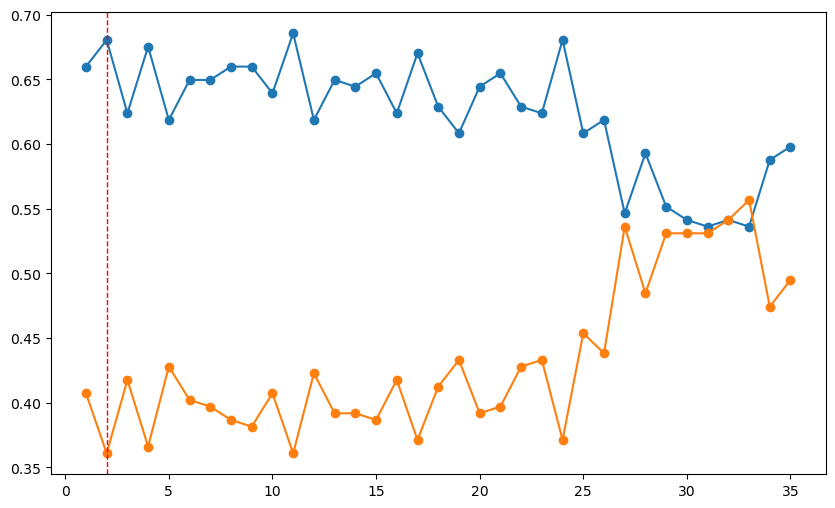

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(results3["num_features_dropped"], results3['accuracy'], marker='o', linestyle='-', label='Accuracy')
plt.plot(results3["num_features_dropped"], results3['mean_absolute_error'], marker='o', linestyle='-', label='MAE')
plt.axvline(
    x=results3.loc[results3['feature_dropped'].apply(lambda x: x[-1] == "primary_max_days" if isinstance(x, list) and x else False), 'num_features_dropped'].values[0], 
    color='r', linestyle='--', linewidth=1, label='Time to measure primary outcomes DROPPED')
plt.axvline(
    x=results3.loc[results3['feature_dropped'].apply(lambda x: x[-1] == "secondary_max_days" if isinstance(x, list) and x else False), 'num_features_dropped'].values[0], 
    color='b', linestyle='--', linewidth=1, label='Time to measure secondary outcomes DROPPED')
plt.title('Feature Ablation')
plt.xlabel('Number of Features Dropped')
plt.ylabel('Model Performance Metrics')
plt.legend()  # Show legend
plt.grid(True)
plt.show()

In [19]:
drop_features = results3.loc[results3['mean_absolute_error'].idxmin(), 'feature_dropped']
drop_features

['survival_5yr_relative',
 'num_inclusion',
 'has_dmc',
 'enroll_count',
 'biological_intervention']

In [15]:
X_train_dropped = X_train.drop(columns=drop_features)
X_test_dropped = X_test.drop(columns=drop_features)

# Retrain the model
rf_model.fit(X_train_dropped, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_dropped)
# y_pred_proba = rf_model.predict_proba(X_test_dropped)[:, 1]

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average='weighted')
mae = mean_absolute_error(y_test, y_pred)

row = {
    # 'feature_dropped': features_dropped.copy(),
    'accuracy': acc,
    'precision': pre,
    'mean_squared_error': mse,
    'mean_absolute_error': mae
}

In [16]:
row

{'accuracy': 0.6597938144329897,
 'precision': np.float64(0.6525068883316306),
 'mean_squared_error': np.float64(0.5257731958762887),
 'mean_absolute_error': np.float64(0.4020618556701031)}

In [17]:
# current = os.getcwd()
# parent = os.path.dirname(current)

# save_path = os.path.join(parent, 'figures', 'feature_ablation.png')
# save_path

In [18]:
# dfi.export(styled_df, save_path)